In [2]:
# Import phase if every import is here it is to allow you to run this cell and know if you have any issue and not after a few hours of training

import tensorflow
from tensorflow import keras
import os
import numpy as np
import librosa

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Activation, Flatten, MaxPooling1D, BatchNormalization, LSTM, GaussianNoise
from tensorflow.keras.models import Sequential


from src.VoiceModule import VoiceModule
from src.classifiers.KerasClassifier import KerasClassifier
from prepare_data_utils import load_wav, preprare_wav, split_sample


In [3]:
# print environment
folder_path = "../../data/keywords"
for l in os.listdir(folder_path):
    print(l)

down
tree
_background_noise_
go
house
validation_list.txt
eight
up
bed
two
dog
no
bird
five
marvin
seven
four
visual
happy
nine
data_speech_commands_v0.02.tar.gz
off
yes
forward
follow
README.md
cat
three
on
right
backward
testing_list.txt
sheila
wow
.DS_Store
stop
one
zero
six
learn
LICENSE
left


In [4]:
# Transform data method

def mfcc(buffer, samplerate, dim):
    a = librosa.feature.mfcc(y=buffer, sr=samplerate, n_mfcc=dim)
    a = np.transpose(a)
    return a


In [5]:
# Create callback to later draw some graphs

class PerformanceLogger(Callback):
    def __init__(self):
        # List of tuple (loss, accuracy)
        self.training = []
        self.testing = []
    def on_epoch_end(self, epoch, logs=None):
        self.training.append((logs["loss"], logs["acc"]))
        self.testing.append((logs["val_loss"], logs["val_acc"]))

In [6]:
# Create class
class EmotionClassifierCnn(KerasClassifier):
    def __init__(self, file_path=None):
        super().__init__(file_path)

    def predict(self, x):
        x = np.expand_dims(np.array([x]), axis=2)
        return self._model.predict(x)

    def build(self):
        model = Sequential()
        # Adding noise to the training data
        model.add(GaussianNoise(0.2))
        
        # feature Extraction layers
        model.add(BatchNormalization())
        model.add(Conv1D(256, 3, input_shape=(50, 13), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(128, 3, input_shape=(50, 13), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(64, 3, input_shape=(50, 13), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(64, 3, input_shape=(50, 13), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        
        # End of the neuron and classification part
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(BatchNormalization())
        model.add(Dense(128))
        model.add(Dense(35))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self._model = model
        
    def train(self, X, Y, batch_size=32, epoch=720, validation_data=None, callbacks=[]):
        self._model.fit(X, Y, batch_size=batch_size, epochs=epoch, validation_data=validation_data, callbacks=callbacks)

    def transform(self, x, samplerate):
        to_process = mfcc(x, samplerate, 13)
        to_process = pad_sequences([to_process], maxlen=50, padding='post')[0]
        return to_process


In [7]:
#Instanciate model
digit_list = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
keyword_list = ["backward", "bed", "bird", "cat", "dog", "down", "follow", "forward",
               "go", "happy", "house", "learn", "left", "marvin", "no", "off", "on",
               "right", "sheila", "stop", "tree", "up", "visual", "wow", "yes"] + digit_list
print(len(keyword_list))
dimension_mfcc = 13
samplerate = 16000
nb_break=None
sample_duration=1
step=1

logger = PerformanceLogger()

cls = EmotionClassifierCnn()
vm = VoiceModule("digit", keyword_list, cls)

35
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [39]:
# Prepare data for training
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in keyword_list}
X, Y = preprare_wav(data, vm, sample_duration, step)
print("Done", X.shape)

Doing backward
Doing bed
Doing bird
Doing cat
Doing dog
Doing down
Doing follow
Doing forward
Doing go
Doing happy
Doing house
Doing learn
Doing left
Doing marvin
Doing no
Doing off
Doing on
Doing right
Doing sheila
Doing stop
Doing tree
Doing up
Doing visual
Doing wow
Doing yes
Doing zero
Doing one
Doing two
Doing three
Doing four
Doing five
Doing six
Doing seven
Doing eight
Doing nine
Done (95394, 50, 13)


In [8]:
X_file = f"x_{'_'.join(keyword_list)}-{vm._name}.npy"
Y_file = f"y_{'_'.join(keyword_list)}.npy"

In [53]:
# Saving the prepared input data 
np.save(X_file, X)
np.save(Y_file, Y)


In [9]:
# Load data for training
X, Y = np.load(X_file), np.load(Y_file)


In [10]:
"""train_size = 80 * len(X) // 100
test_size = 20 * len(X) // 100
#X = np.expand_dims(X, axis=3)
X_train, X_test, = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]"""
X = X.astype('float32')
print(X.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

print(X[0].shape)
print( X.dtype)

(95394, 50, 13)
76315 19079
(50, 13)
float32


In [11]:
vm.model.train(X_train, Y_train, batch_size=512, epoch=100, validation_data=(X_test, Y_test), callbacks=[logger])

Train on 76315 samples, validate on 19079 samples
Epoch 1/100
76315/76315 [==============================] - 20s 261us/sample - loss: 2.0254 - acc: 0.4267 - val_loss: 1.3400 - val_acc: 0.6894
Epoch 2/100
76315/76315 [==============================] - 17s 220us/sample - loss: 0.8849 - acc: 0.7377 - val_loss: 0.7107 - val_acc: 0.8096
Epoch 3/100
76315/76315 [==============================] - 17s 218us/sample - loss: 0.6254 - acc: 0.8148 - val_loss: 0.5215 - val_acc: 0.8514
Epoch 4/100
76315/76315 [==============================] - 17s 218us/sample - loss: 0.5139 - acc: 0.8477 - val_loss: 0.4936 - val_acc: 0.8511
Epoch 5/100
76315/76315 [==============================] - 17s 226us/sample - loss: 0.4485 - acc: 0.8664 - val_loss: 0.3600 - val_acc: 0.8922
Epoch 6/100
76315/76315 [==============================] - 16s 216us/sample - loss: 0.3894 - acc: 0.8850 - val_loss: 0.3392 - val_acc: 0.9003
Epoch 7/100
76315/76315 [==============================] - 17s 216us/sample - loss: 0.3516 - acc: 

76315/76315 [==============================] - 19s 251us/sample - loss: 0.0576 - acc: 0.9816 - val_loss: 0.2989 - val_acc: 0.9406
Epoch 59/100
76315/76315 [==============================] - 19s 246us/sample - loss: 0.0660 - acc: 0.9798 - val_loss: 0.3089 - val_acc: 0.9399
Epoch 60/100
76315/76315 [==============================] - 19s 243us/sample - loss: 0.0468 - acc: 0.9855 - val_loss: 0.3117 - val_acc: 0.9390
Epoch 61/100
76315/76315 [==============================] - 18s 232us/sample - loss: 0.0569 - acc: 0.9818 - val_loss: 0.3293 - val_acc: 0.9365
Epoch 62/100
76315/76315 [==============================] - 17s 225us/sample - loss: 0.1299 - acc: 0.9621 - val_loss: 0.3174 - val_acc: 0.9345
Epoch 63/100
76315/76315 [==============================] - 17s 218us/sample - loss: 0.0566 - acc: 0.9817 - val_loss: 0.2843 - val_acc: 0.9393
Epoch 64/100
76315/76315 [==============================] - 17s 217us/sample - loss: 0.0443 - acc: 0.9860 - val_loss: 0.2878 - val_acc: 0.9408
Epoch 65/100

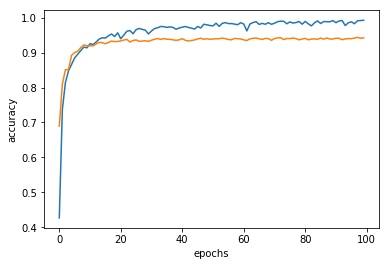

In [12]:

plt.plot(list(range(0, len(logger.training))), list(map(lambda x:x[1], logger.training)), label="training data")
plt.plot(list(range(0, len(logger.testing))), list(map(lambda x:x[1], logger.testing)), label="testing data")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [13]:
vm.model.save("keyword-cnn.model")

In [15]:
# Now we load the new dataset (savee)
emotion_list = ["calm", "happy", "angry", "fearful", "surprised", "sad"]
# First we change the folder path
# folder_path += "/savee"

# Now we load the data
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X_savee, Y_savee = preprare_wav(data, vm, sample_duration, step)

ValueError: 'calm' is not in list

In [ ]:
vm.model._model.evaluate(X_savee, Y_savee)

In [ ]:
# Now we freeze every layer used for extracting features from data
fine_tuned_model = Sequential(vm.model._model.layers[:-6])
fine_tuned_model.add(Dense(128))
fine_tuned_model.add(Dense(35))
fine_tuned_model.add(Activation('softmax'))
fine_tuned_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

for layer in fine_tuned_model.layers[:-3]:
    print(layer.name)
    layer.trainable = False
vm.model._model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])